In [1]:
import os
import pickle
import time
import spacy
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
sns.set()
import pandas as pd
import collections
import pickle
import re
import json
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics

In [2]:
# uncomment if first time use
# !pip install mxnet-cu101 --target=$nb_path 

import mxnet as mx
from mxnet.gluon import nn, loss as gloss, rnn
from mxnet.gluon import data as gdata
from mxnet import gluon
from mxnet import nd,init
from mxnet.contrib import text
from mxnet import autograd

In [3]:
with open('./company_data.pickle', 'rb') as f:
    comp_data = pickle.load(f)
with open('./noun_verb_df.pickle', 'rb') as f:
    df = pickle.load(f)
df.head()

,text,target,filename,nouns,verbs
11922,Home - Coach aan Boord HomeCoachingstrajectenU...,16,595570,coach contact stuurman wal stuurman boord coac...,zijn moeten worden uitvoeren kunnen leren kunn...
4780,iMorang ICT SolutionsSterk in maatwerk softwar...,8,681629,solutionssterk maatwerk automatisering onderhoud,
13805,Enriching MomentsContact FormNameCompany nameC...,18,489353,enriching formnamecompany,
6822,Me&Maureen - Impact by Experience!Me and Maure...,9,459700,storie experiencecelebrating year heinekenom b...,
19156,info@allerleiklussen.nl 0521-589257 Toggle nav...,6,435558,overzichtschilderklussenklik overzichtallerlei...,navigationhomeallerleibuitenklussenschilderklu...


Calculate noun length and verb length, filter out those with total length than 30, we remove almost half of the data. Half of the data contains little information, perhaps due to scraping issues

In [4]:
df['noun_len'] = df['nouns'].apply(lambda x: len(x.split(" ")))
df['verb_len'] = df['verbs'].apply(lambda x: len(x.split(" ")))
df = df[df['noun_len'] + df['verb_len'] > 30]

(11090, 19)

In [7]:
def LR(out_dim):
    net = nn.Sequential()
    net.add(nn.Dense(out_dim))
    net.initialize(init.Xavier())
    return net

def evaluate(net, iter):
    corr, n = 0, 0
    for batch in iter:
        X, y = batch
        out = net(X)
        corr += nd.sum(out.argmax(axis=1) == y.astype('float32')).asscalar() 
        n += y.size
    return corr/ n

def train(net, train_iter, test_iter, trainer, loss, num_epoch = 100, verbose=True):
    train_acc, test_acc = [evaluate(net, train_iter)], [evaluate(net, test_iter)]
    print("Before training, train acc: %.3f, test acc: %.3f"                   
          % (train_acc[-1], test_acc[-1]))
    for i in range(num_epoch):
        start = time.time()
        for batch in train_iter:
            X, y = batch
            with autograd.record():
                output = net(X)
                l_sum = loss(output, y)
            l_sum.backward()
            trainer.update(len(y))
        train_acc.append(evaluate(net, train_iter))
        test_acc.append(evaluate(net, test_iter))
        if verbose and (i+1)%5 == 0:
            print("epoch %d, train acc: %.3f, test acc: %.3f, time: %.3f" 
                  % (i+1, train_acc[-1], test_acc[-1], time.time() - start))
    plot_conv_line(train_acc, test_acc)
    return (train_acc, test_acc)

def plot_conv_line(train_acc, test_acc):
    x = np.arange(len(train_acc))
    plt.plot(x, train_acc, label='train_acc')
    plt.plot(x, test_acc, label='test_acc')
    plt.legend()
    plt.show()

In [13]:
def print_top(label_names, top=10):
    top = nd.argsort(net[0].weight.data(), axis=1, is_ascend=False)[:, :top]
    top = top.asnumpy().astype('int32')
    names = [[vectorizer.get_feature_names()[idx] for idx in group] for group in top]
    for i, (words, label) in enumerate(zip(names, label_names)):
        print(f"{i}. {label.upper()}:\n {', '.join(words)}")

In [10]:
def get_top_weight(n=10):
    return nd.sort(net[0].weight.data(), axis=1, is_ascend=False)[:, :n]
def predict(net, df, label_names):
    
    def to_label(yhats):
        return [label_names[i] for i in yhats.astype('int32').tolist()]
  

    X = vectorizer.transform(df['nouns'] + ' ' + df['verbs'])
    X = nd.array(X.toarray())
    out = net(X)
    yhats = out.argmax(axis = 1).asnumpy().astype('int32')
    df = pd.DataFrame({'filename': df['filename'], 'predict_label': to_label(yhats), 'predict': yhats, 'target_label': to_label(df['target']), 'target': df['target']})
    return df

In [70]:
def get_confusion_matrix(y_true, y_predict, shape=20):
    arr = np.zeros(shape=(shape,shape), dtype='int32')
    for y, yhat in zip(y_true, y_predict):
        arr[y,yhat] += 1
    return arr

def plot_confusion_matrix(y_true, y_predict, shape=20):
    confusion_matrix = get_confusion_matrix(y_true, y_predict, shape)
    plt.figure(figsize=(10,6))
    sns.heatmap(confusion_matrix, annot=True, fmt='d')
    plt.show()

/Users/septem/opt/miniconda3/envs/da/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='target', ylabel='count'>

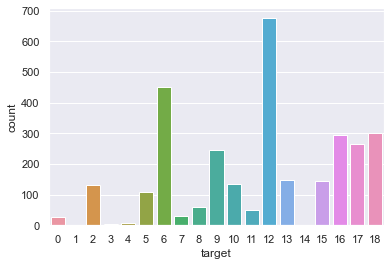

In [191]:
sns.countplot(df['target'])

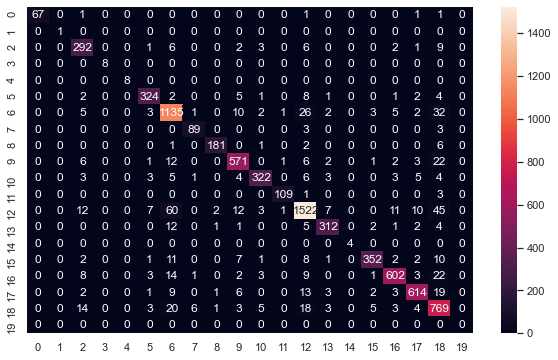

In [212]:
y_predict, y_true = predict(net, df_train, comp_data['target_names'])['predict'], df_train['target']
plot_confusion_matrix(y_true, y_predict)

In [213]:
sum(y_predict == y_true) / len(y_true)

0.91025

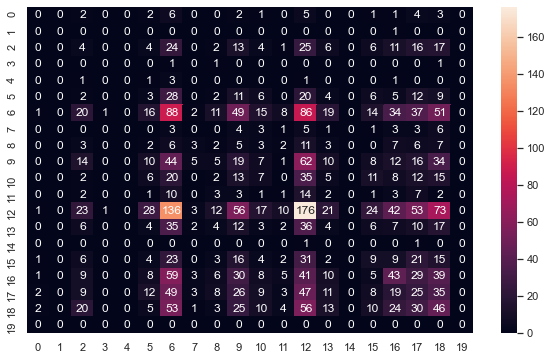

In [214]:
y_predict, y_true = predict(net, df_test, comp_data['target_names'])['predict'], df_test['target']
plot_confusion_matrix(y_true, y_predict)

In [216]:
sum(y_predict == y_true)/len(y_true)

0.13818770226537216

In [217]:
[target_names[idx] for idx in [6,9,12,16,17,18]]

['Groot- en detailhandel; reparatie van auto’s',
 'Informatie en communicatie',
 'Advisering, onderzoek en overige specialistische zakelijke dienstverlening',
 'Gezondheids- en welzijnszorg',
 'Cultuur, sport en recreatie',
 'Overige dienstverlening']

Visualize the data

In [222]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [227]:
lda = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda.fit(X_train.toarray(), Y_train).transform(X_train.toarray())

In [278]:
def show_projection(X_r, cls = 20):
    figure = plt.figure()
    for i, target_name in zip(np.arange(0,cls), target_names):
        plt.scatter(X_r[Y_train == i, 0], X_r[Y_train == i, 1], alpha=.8,
                    label=target_name)

    # create a second figure for the legend
    legFigure = plt.figure()
    ax2 = legFigure.gca()

    legFigure.patch.set_visible(False)
    ax2.axis('off')
    # produce a legend for the objects in the other figure
    ax2.legend(*ax.get_legend_handles_labels())


LDA projection, much better

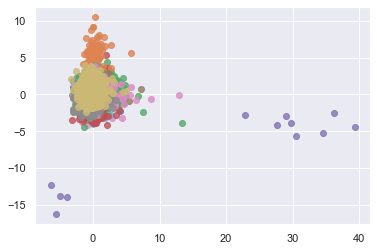

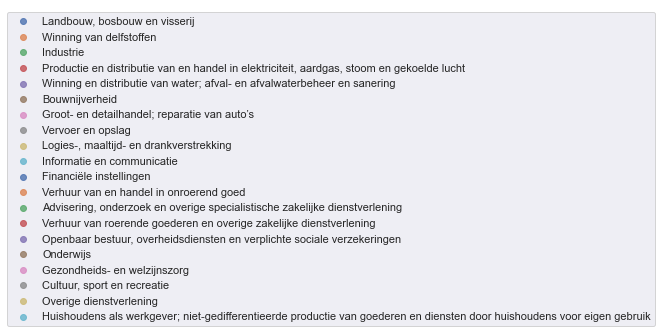

In [279]:
show_projection(X_r2)

In [25]:
[(i,name) for i,name in enumerate(target_names) if 'dienst' in name]

[(12,
  'Advisering, onderzoek en overige specialistische zakelijke dienstverlening'),
 (13, 'Verhuur van roerende goederen en overige zakelijke dienstverlening'),
 (14,
  'Openbaar bestuur, overheidsdiensten en verplichte sociale verzekeringen'),
 (18, 'Overige dienstverlening'),
 (19,
  'Huishoudens als werkgever; niet-gedifferentieerde productie van goederen en diensten door huishoudens voor eigen gebruik')]

In [33]:
def get_new_labels(old_names, idx_to_group, new_group_name):
    new_names = []
    for i, name in enumerate(old_names):
        if i not in idx_to_group:
            new_names.append(name)
    new_names.append(new_group_name)
    return new_names

Group some similar classes into one group

In [41]:
new_target_names = get_new_labels(target_names, [6,9,12,13,14,18,19], 'dienstverlening')
new_name_to_idx = {name: i for i,name in enumerate(new_target_names)}

In [51]:
def update_idx(idx, old_names, new_name, new_name_to_idx):
    name = old_names[idx]
    new_idx = new_name_to_idx.get(name, len(new_target_names)-1)
    return new_idx

In [53]:
df['target'] = df['target'].apply(lambda x: update_idx(x, target_names, new_target_names, new_name_to_idx))

/Users/septem/opt/miniconda3/envs/da/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='target', ylabel='count'>

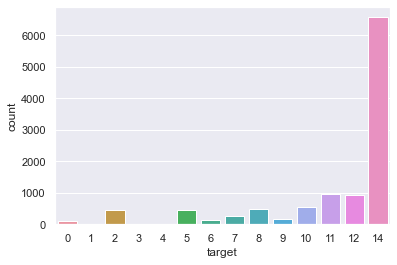

In [54]:
sns.countplot(df['target'])

In [76]:
n_train = 8000
out_dim = 15
df_train = df.iloc[:n_train]
df_test = df.iloc[n_train:]
vectorizer = TfidfVectorizer(max_df=0.5, min_df = 5, sublinear_tf=True)
X_train = vectorizer.fit_transform(df_train['nouns'] + ' ' + df_train['verbs'])
Y_train = df_train['target']
X_test = vectorizer.transform(df_test['nouns'] + ' ' + df_test['verbs'])
Y_test = df_test['target']
batch_size = 128
train_set = gdata.ArrayDataset(nd.array(X_train.toarray()), nd.array(Y_train))
test_set = gdata.ArrayDataset(nd.array(X_test.toarray()), nd.array(Y_test))
train_iter = gdata.DataLoader(train_set, shuffle=True, batch_size=batch_size)
test_iter = gdata.DataLoader(test_set, batch_size=batch_size)

Before training, train acc: 0.063, test acc: 0.062
epoch 5, train acc: 0.969, test acc: 0.496, time: 0.726
epoch 10, train acc: 0.971, test acc: 0.492, time: 0.703
epoch 15, train acc: 0.967, test acc: 0.486, time: 0.759
epoch 20, train acc: 0.971, test acc: 0.483, time: 0.697
epoch 25, train acc: 0.972, test acc: 0.508, time: 0.693
epoch 30, train acc: 0.971, test acc: 0.463, time: 0.704


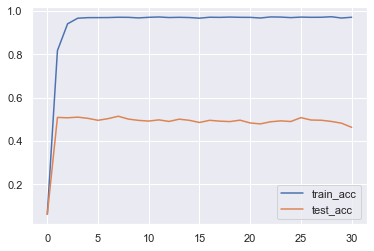

In [89]:
net = LR(out_dim)
loss = gloss.SoftmaxCrossEntropyLoss()
lr, wd, num_epoch = 0.1, 0, 30
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': lr, 'wd': wd})
train_acc, test_acc = train(net, train_iter, test_iter, trainer, loss, num_epoch)

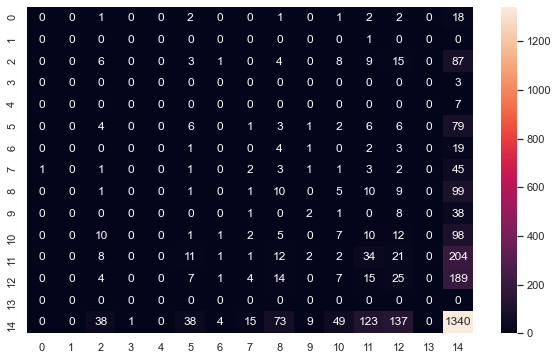

In [120]:
y_predict, y_true = predict(net, df_test, new_target_names)['predict'], df_test['target']
plot_confusion_matrix(y_true, y_predict, shape=out_dim)

In [96]:
print_top(new_target_names, 20)

0. LANDBOUW, BOSBOUW EN VISSERIJ:
 evenement, copyright, publiceren, aanvulling, werkzaamheid, onderwerp, examen, groeien, voordeel, rust, prestatie, verzend, element, specializing, volgen, avanceren, retourner, pakket, robot, bieden
1. WINNING VAN DELFSTOFFEN:
 aar, vertegenwoordigen, gezondheidscentrum, discipline, geleiden, pand, bereiken, centrum, telefoonnummer, foto, vestigen, gaan, zien, werken, naam, vraag, site, weldoordacht, portalcontactvoor, vergadertip
2. INDUSTRIE:
 verdermeer, consulting, everything, album, draaiboek, samenwerken, buis, pot, oprichten, studie, bus, data, setting, aanbouw, black, doorontwikkeling, reportage, onbeperkt, voornaam, tweets
3. PRODUCTIE EN DISTRIBUTIE VAN EN HANDEL IN ELEKTRICITEIT, AARDGAS, STOOM EN GEKOELDE LUCHT:
 droomkeuk, uitzoeken, leidingwerk, winst, werkzaamheid, ophalen, onderstaan, afvoeren, schilderwerk, beschadiging, behoud, bevestiging, kras, zonde, camper, omgevingsvergunning, trouw, google, regie, moderator
4. WINNING EN DISTRI

In [95]:
df[df['target'] == 10].head()

,text,target,filename,nouns,verbs,noun_len,verb_len
6119,Home Praktijk MCSpraktijk voor remedial teachi...,10,92269,praktijk website praktijk naam jaar leerkracht...,voorstellen zijn zijn zijn zijn vestigen onder...,32,17
7062,Borealis ITWelkomProductOntwikkelingVisieConta...,10,604642,maatwerk oplossing informatie afspraak website...,opplossingen zijn maken specialiseren automati...,27,15
17383,Alken Development - Web- & applicatiedevelopme...,10,205923,alk webdeveloperalk development website webapp...,zijn specialiseren kijken zijn specialiseren o...,73,31
9579,absterjansen | Creative writerabsterjansen | w...,10,208330,welcometoggle passion record been several look...,writerabsterjansen zijn unique what beauty zijn,28,6
13851,Buitengewoon Feest! - Natuurlijke kinderfeestj...,10,200903,feest kinderfeestjestoggle informatiecontactvr...,gaan vinden kunnen zijn zijn hebben bedenken n...,42,14


In [116]:
edu_df = df[df['target'] == 10][:20]
edu_df

,text,target,filename,nouns,verbs,noun_len,verb_len
6119,Home Praktijk MCSpraktijk voor remedial teachi...,10,92269,praktijk website praktijk naam jaar leerkracht...,voorstellen zijn zijn zijn zijn vestigen onder...,32,17
7062,Borealis ITWelkomProductOntwikkelingVisieConta...,10,604642,maatwerk oplossing informatie afspraak website...,opplossingen zijn maken specialiseren automati...,27,15
17383,Alken Development - Web- & applicatiedevelopme...,10,205923,alk webdeveloperalk development website webapp...,zijn specialiseren kijken zijn specialiseren o...,73,31
9579,absterjansen | Creative writerabsterjansen | w...,10,208330,welcometoggle passion record been several look...,writerabsterjansen zijn unique what beauty zijn,28,6
13851,Buitengewoon Feest! - Natuurlijke kinderfeestj...,10,200903,feest kinderfeestjestoggle informatiecontactvr...,gaan vinden kunnen zijn zijn hebben bedenken n...,42,14
3435,Home HomeMegaPeelSkinSonicBindweefselmassageLy...,10,588236,huid behandelmethode buitenkant huid beeld kla...,zonnen zijn baseren krijgen zaken zonnen worde...,46,23
18442,scooter reparatie Heerhugowaard Alkmaar Bergen...,10,681862,scooter reparatie site scooter gemak pech werk...,zijn richten verlenen komen onderhouden zijn k...,57,19
17385,\tJust Right ITJR-ITHomeContactDienstenConsult...,10,205967,telefoniehosting klant referentiesmaak kennis ...,betekenendienstenwij moeten werken zijn zijn f...,47,12
9555,Home - Whats NexxtHomeTrainingDe SherpaRechtsa...,10,71487,what what what nexxtblogcontact what training ...,verfrissen baseren denken klikken helpen krijg...,31,23
961,BANDenkennis - BANDENREPARATIE - VENTIELEN & T...,10,231027,bandenkenni navigationhomeopleidingenbandenrep...,zijn zijn houden vergroten vertrouwen afbakene...,46,7


In [123]:
predict(net, edu_df, new_target_names)

,filename,predict_label,predict,target_label,target
6119,92269,Onderwijs,10,Onderwijs,10
7062,604642,Onderwijs,10,Onderwijs,10
17383,205923,Onderwijs,10,Onderwijs,10
9579,208330,Onderwijs,10,Onderwijs,10
13851,200903,Onderwijs,10,Onderwijs,10
3435,588236,Onderwijs,10,Onderwijs,10
18442,681862,Onderwijs,10,Onderwijs,10
17385,205967,Onderwijs,10,Onderwijs,10
9555,71487,Onderwijs,10,Onderwijs,10
961,231027,Onderwijs,10,Onderwijs,10


In [112]:
id_code = pd.read_csv('/Users/septem/Downloads/com_data/id_code.csv`', sep=';', dtype='string')
id_code = id_code.set_index('ID', drop=True, verify_integrity=True)

In [118]:
id_code.head()

,SbicodeActueel
ID,
58,960900
76,465200
84,855990
230,889991
266,454020


In [119]:
id_code.loc[edu_df['filename']]

,SbicodeActueel
ID,
92269,855990
604642,855190
205923,855990
208330,855990
200903,855990
588236,855990
681862,855300
205967,855920
71487,855920


PCA projection is not working

In [276]:
pca = PCA(n_components=2)
X_r = pca.fit(X_train.toarray()).transform(X_train.toarray())

In [281]:
# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

explained variance ratio (first two components): [0.01032431 0.00920521]


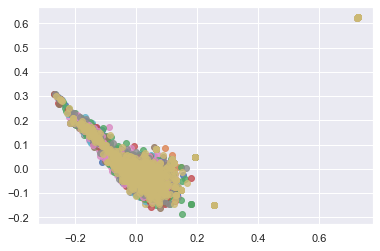

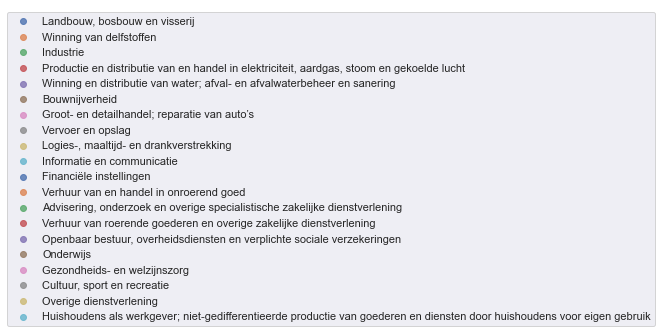

In [280]:
show_projection(X_r)